## PyTorch Workflow

Pytorch end-to-end workflow.
1. Prepare and load data
2. Build model
3. Fitting the model to data (training)
4. Make predictions and evaulating model
5. Saving and loading model

### 1. Prepare and load data

In [33]:
import torch
from torch import nn # nn contains all the building blocks for model in pytorch
import matplotlib.pyplot as plt

In [34]:
weight = 0.8
bias = 0.3
start = 0
end = 1
 
X = torch.arange(start, end, step=0.1).unsqueeze(dim=1)
y = weight * X + bias

#### Splitting data into training and test sets

In [35]:
train_split = int(0.8 * len(X))
Xtrain, ytrain = X[:train_split], y[:train_split]
Xtest, ytest = X[train_split:], y[train_split:]

#### Plot the model data

In [36]:
import matplotlib.pyplot as plt

def dataplot(ypred=None):
    # create a figure
    fig, ax = plt.subplots()

    ax.scatter(Xtrain, ytrain, color='blue', label='Training Data')
    ax.scatter(Xtest, ytest, color='red', label='Test Data')
    if ypred is not None:
        ax.scatter(Xtest, ypred, color='green', label='Prediction Result')
    ax.legend()    
    plt.show()

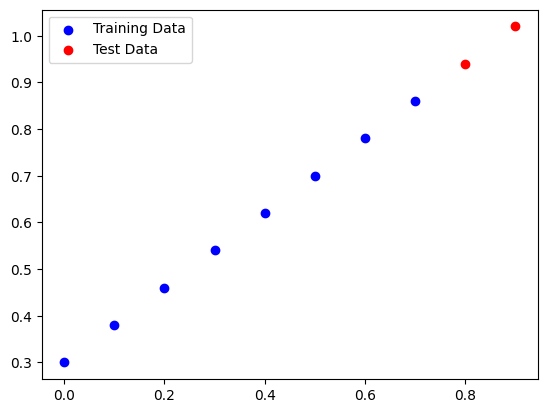

In [37]:
dataplot()

### 2. Build a model

In [38]:
from torch import nn

# create linear regression model class
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1,
                                                requires_grad=True,
                                                dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True,
                                             dtype=torch.float))
    # Forward method to define the computation in the model    
    def forward(self, x:torch.Tensor)->torch.tensor:
        return self.weights * x + self.bias

#### Checking the contents of our model

In [39]:
# set random seed
torch.manual_seed(42)

# create instance of our model
model = LinearRegressionModel()
list(model.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [40]:
# List named parameters
model.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

#### Making predictions using `torch.inference_mode()`

In [41]:
# beaucse we have no intention of updating the model’s parameters through gradient descent jsut use inference mode
with torch.inference_mode():
    ypred = model(Xtest)
ypred.numpy()

array([[0.3981617],
       [0.4318307]], dtype=float32)

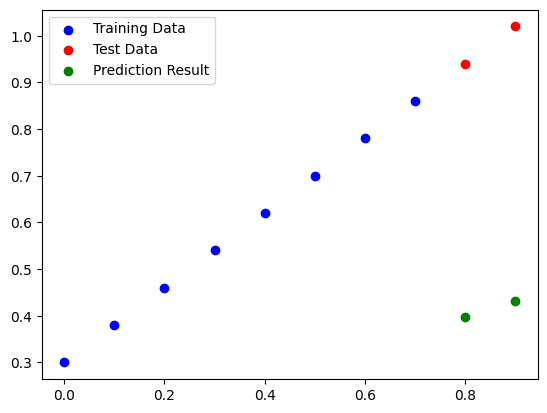

In [42]:
dataplot(ypred)

### 3. Train Model
The whole prcedure of trainig is to quantify how well a model is performing its task by comparing predicted outputs to ground truth labels.

We need things:
+ **Loss function**
+ **Optimizer**  
  

In [43]:
# set up loss function
loss_fn = nn.L1Loss()

# setup optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.01)

#### Bulding a training loop (and a testing loop)

In [44]:
ypred, ytrain

(tensor([[0.3982],
         [0.4318]]),
 tensor([[0.3000],
         [0.3800],
         [0.4600],
         [0.5400],
         [0.6200],
         [0.7000],
         [0.7800],
         [0.8600]]))

In [45]:
# An epoch is one loop through the data
epochs = 100
train_loss_values = []
test_loss_values = []
epoch_count = []

# 0. Loop through the data
for epoch in range(epochs):
    # Set the model to training mode
    model.train() # train mode in pytorch sets all parameters that require gradients

    # 1. Forward the train data in the model
    ypred = model(Xtrain)

    # 2. Calculate the loss
    loss = loss_fn(ypred, ytrain)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Perform backpropagation on the loss
    loss.backward()

    # 5. Step the optimizer 
    optimizer.step()

    model.eval() # turns of different settings in the model not needed for evaluation

    with torch.inference_mode():
        # 1. Forward pass on test data
        test_pred = model(Xtest)

        # 2. Caculate loss on test data
        test_loss = loss_fn(test_pred, ytest.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

        # Print out what's happening
        if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.33334898948669434 | MAE Test Loss: 0.5520287752151489 
Epoch: 10 | MAE Train Loss: 0.2210988849401474 | MAE Test Loss: 0.42227861285209656 
Epoch: 20 | MAE Train Loss: 0.11980123817920685 | MAE Test Loss: 0.300028532743454 
Epoch: 30 | MAE Train Loss: 0.0801452174782753 | MAE Test Loss: 0.22554105520248413 
Epoch: 40 | MAE Train Loss: 0.06666184216737747 | MAE Test Loss: 0.18030348420143127 
Epoch: 50 | MAE Train Loss: 0.06266183406114578 | MAE Test Loss: 0.1633034646511078 
Epoch: 60 | MAE Train Loss: 0.058661844581365585 | MAE Test Loss: 0.14630350470542908 
Epoch: 70 | MAE Train Loss: 0.05466189607977867 | MAE Test Loss: 0.1293037235736847 
Epoch: 80 | MAE Train Loss: 0.05066194757819176 | MAE Test Loss: 0.11230394244194031 
Epoch: 90 | MAE Train Loss: 0.04726198688149452 | MAE Test Loss: 0.10535413026809692 


In [46]:
# Prediction after some training
with torch.inference_mode():
    testPred = model(Xtest)
    # Calculate test loss
    test_loss = loss_fn(testPred, ytest)
    print(f"Test Loss: {test_loss}")

Test Loss: 0.10010430216789246


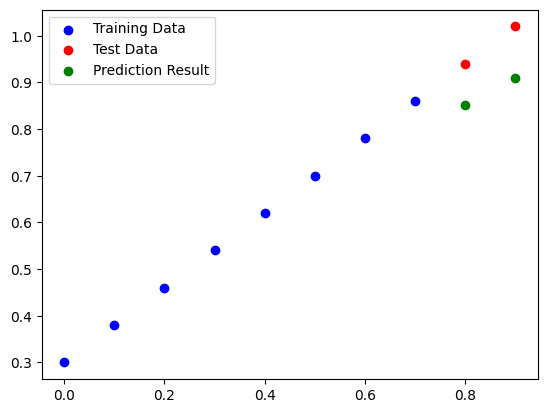

In [49]:
dataplot(testPred)

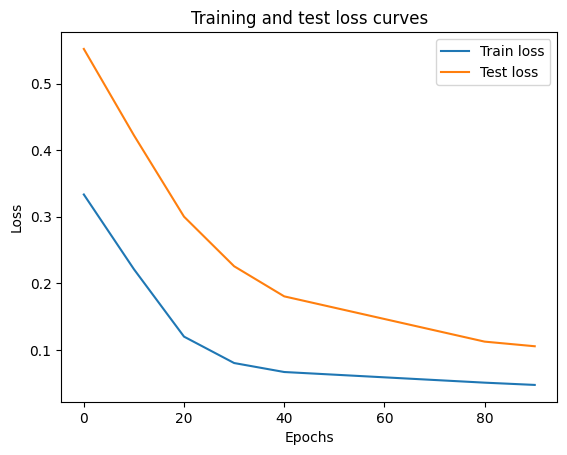

In [48]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

#### Saving a model
There are three method for saving and loading models in PyTorch:

1. `torch.save()` save a PyTorch object in Python's pickle format
2. `torch.load()`
3. `torch.nn.Module.load_state_dict()`

 Pros and Cons:
 - State_dict:
   - Pros: Lightweight (only learnable parameters), flexible (can change model architecture), compatible across PyTorch versions.
   - Cons: Requires rebuilding the model architecture when loading.
 - Entire Model:
   - Pros: Includes architecture, methods, and parameters, easy to load.
   - Cons: Larger file size, less flexible (architecture tied to saved model).

##### Save & Load using `state_dict()`

In [63]:
# Saving our PyTorch model
from pathlib import Path

# 1. Create models directory
MODEL0_PATH = Path("Models")
MODEL0_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL0_NAME = "01_pytorch_workflow_0.pth"
MODEL0_SAVE_PATH = MODEL0_PATH / MODEL0_NAME

# 3. Save the model state dict
print(f"Saving model to {MODEL0_SAVE_PATH}")
torch.save(obj=model.state_dict(),
           f=MODEL0_SAVE_PATH)

Saving model to Models/01_pytorch_workflow_0.pth


In [64]:
# To load state dict we have to create new instance of our model class
loaded_model = LinearRegressionModel()

# Load the state_dict back
loaded_state_dict = torch.load(MODEL0_SAVE_PATH)
loaded_model.load_state_dict(loaded_state_dict)

/tmp/ipykernel_38580/3440810471.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_state_dict = torch.load(MODEL0_SAVE_PATH)


<All keys matched successfully>

##### Save & Load **entire model**

In [65]:
# Saving entire of our PyTorch model
from pathlib import Path

# 1. Create models directory
MODEL1_PATH = Path("Models")
MODEL1_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL1_NAME = "01_pytorch_workflow_1.pth"
MODEL1_SAVE_PATH = MODEL1_PATH / MODEL1_NAME

# 3. Save the model state dict
print(f"Saving model to {MODEL1_SAVE_PATH}")
torch.save(obj=model,
           f=MODEL1_SAVE_PATH)

Saving model to Models/01_pytorch_workflow_1.pth


In [66]:
# Load the entire model back
model_loaded_entire = torch.load(MODEL1_SAVE_PATH)

/tmp/ipykernel_38580/957944023.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_loaded_entire = torch.load(MODEL1_SAVE_PATH)
